# *Bike Sharing Demand - Kaggle Competition*

# Forecast use of a city bikeshare system

https://www.kaggle.com/c/bike-sharing-demand/data

Angela Gunn  
Sayantan Satpati  
Rajesh Thallam

## Import Libraries

pandas (http://pandas.pydata.org/)  
statsmodels (http://statsmodels.sourceforge.net/)  
pylab (http://wiki.scipy.org/PyLab)  
numpy   (http://www.numpy.org/)
matplotlib (http://matplotlib.org/)  
scipy.stats (http://docs.scipy.org/doc/scipy/reference/stats.html)
itertools (https://docs.python.org/2/library/itertools.html)
sklearn (http://scikit-learn.org/stable/)  
os (https://docs.python.org/2/library/os.html)

In [1]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
from scipy.stats import pearsonr

import itertools

from sklearn import linear_model
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import cross_validation
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

import os

%matplotlib inline

# Data Import

##Data Fields
```
01. datetime    - hourly date + timestamp  
02. season      -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
03. holiday     - whether the day is considered a holiday
04. workingday  - whether the day is neither a weekend nor holiday
05. weather     - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
                  2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
                  3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
                  4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
06. temp        - temperature in Celsius
07. atemp       - "feels like" temperature in Celsius
08. humidity    - relative humidity
09. windspeed   - wind speed
10. casual      - number of non-registered user rentals initiated
11. registered  - number of registered user rentals initiated
12. count       - number of total rentals
```

Note the Kaggle Test file does not have fields 10-12.

In [2]:
# import training data set
TRAIN = pd.read_csv("train.csv")
KAGGLE_TEST = pd.read_csv("test.csv")

In [3]:
#preview data
TRAIN.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1


In [4]:
#preview data
KAGGLE_TEST.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


# Exploratory Analysis
## i. Total bike rentals (count) distribution

In [ ]:
#function processDateTime
# purpose: simple function to process datatetime
# df: data frame
# returns data frame
def processDateTime(df):  
    #Create new columns for day, month, year, hour
    df.index = pd.to_datetime(df['datetime']) # creating an index from the timestamp
    df['year'] = pd.DatetimeIndex(df['datetime']).year # year
    df['month'] = pd.DatetimeIndex(df['datetime']).month # month
    df['day'] = pd.DatetimeIndex(df['datetime']).day # day
    df['hours'] = pd.DatetimeIndex(df['datetime']).hour # hour
    df['dayofweek'] = pd.DatetimeIndex(df['datetime']).dayofweek # day of the week 0 = Monday to 6 = Sunday
    df['rownum'] = range(1,len(df)+1) 
    
    return df

#create a dataset for our exploration
explore_data = processDateTime(TRAIN)


In [ ]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
plt.hist(TRAIN['count'], bins =25, color='#5b9bd5')
ax.set_xlabel('data')
ax.set_ylabel('counts')
ax.set_title("Distribution of the Number of Bike Requests")
plt.tight_layout()
plt.show()

## ii. Correlation

In [ ]:
# correlation matrix between all variables
explore_data = explore_data.drop(['datetime'], 1)
correlation = explore_data.corr(method = 'pearson', min_periods = 1)
correlation.describe()

In [ ]:
col_names = explore_data.columns.values.tolist() 
row_names = explore_data.columns.values.tolist()
data = correlation

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(121)
heatmap = ax.pcolor(data, cmap=plt.cm.Greys)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[0])+1, minor=False)
ax.set_yticks(np.arange(data.shape[1])+1, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(row_names, minor=False, rotation='vertical')
ax.set_yticklabels(col_names, minor=False, rotation='horizontal')
plt.show()


Some findings from the correlation matrix

- Well correlated 
  - season and month
  - season and weather  
  - season and temperature
  - season and humidity
  - working day and registered - (obvious) working days means commuters
  - atemp and weather
  - atemp and windspeed
  - atemp and registered
  - atemp and count
  - casual and holiday
  - casual and season
  - casual and windspeed
  - casual and year, hour, day and day of the week
  - casual and atemp
  - casual and median count
  - registered and season
  - registered and atemp
  - registered and windspeed
  - registered and year and hour
  - registered and median
  - count and season
  - count and weather
  - count and atemp
  - count and windspeed
  - count and year, hour
  - count and median

- Somewhat correlated
  - workingday and holiday
  - windspeed and day

###How about checking p-value? (data exploration is fun!)

In [ ]:
n = len(explore_data.columns)
r = [pearsonr(explore_data[[i]], explore_data[[j]]) + (explore_data.columns.values[i], explore_data.columns.values[j]) for i in np.arange(n) for j in np.arange(n)]
r = np.array(r)
r[:, 1] = np.hstack(r[:, 1])
r[:, 0] = np.hstack(r[:, 0])

corr_m = pd.DataFrame(r[:,:], columns=['PearsonR', 'pValue', 'corX', 'corY'])
corr_m['significance'] = corr_m.apply(lambda row: '***' if row[1] <= .001 else '**' if row[1] <= .01 else '*' if row[1] <= .01 else '-', axis=1)

corr_m.query(' PearsonR != 1 and significance != "-" and corX != "rownum" and corY != "rownum" and ( PearsonR >= 0.3 or PearsonR <= -0.3) ')

And a few more fun charts!

These charts show the histogram on the diagonal, and scatter plots elsewhere against the variables on the axis. The graphs are symetrical on the diagonal axis.

This visual confirms some of our assumptions on the data.

In [ ]:
_ = pd.tools.plotting.scatter_matrix(explore_data.ix[:,5:12], figsize=(15,10), diagonal='hist', color='brown')

In [ ]:
_ = pd.tools.plotting.scatter_matrix(explore_data.ix[:,10:16], figsize=(15,10), diagonal='hist', color='brown')

#### Why casual and registered users should be modeled separately?

In [ ]:
fig = plt.figure(figsize=(15,8))
ax1 = plt.subplot(221); ax1.set_title("Total Ridership 'Count'")
ax1.plot(explore_data['count'])
ax2 = plt.subplot(223); ax2.set_title("'Casual' Ridership")
ax2.plot(explore_data['registered'])
ax3 = plt.subplot(224); ax3.set_title("'Registered' Ridership")
ax3.plot(explore_data['casual'])

plt.tight_layout()
plt.show()

The above charts show casual and registered ridership follows very different patterns.

## iii. Exploratory analysis

Here we will create a set of plots that will show patterns in the data

In [ ]:
# data exploratory analysis
fig = plt.figure(figsize=(15,20))

pl.subplots_adjust(hspace=0.000)
number_of_subplots=18

col_names = ['count', 'temp', 'humidity', 'windspeed', 'atemp', 'month']
no_of_axes = 3

for v in np.arange(0, number_of_subplots, 3):
    ax1 = pl.subplot(number_of_subplots/3, 3, v+1)
    ax1.plot(explore_data[col_names[v/3]], color='#5b9bd5')
    ax1.set_xlabel("datetime")
    ax1.set_ylabel(col_names[v/3])
    ax1.set_title('time series of ' + col_names[v/3])
    
    ax2 = pl.subplot(number_of_subplots/3, 3, v+2)
    ax2.hist(explore_data[col_names[v/3]], color='#5b9bd5')
    ax2.set_xlabel(col_names[v/3])
    ax2.set_ylabel("density")
    ax2.set_title('histogram of ' + col_names[v/3])

    ax3 = pl.subplot(number_of_subplots/3, 3, v+3)
    ax3.scatter(explore_data[col_names[v/3]], explore_data['count'], color='red')
    ax3.set_xlabel(col_names[v/3])
    ax3.set_ylabel("count")
    ax3.set_title('scatter plot of ' + col_names[v/3])
    
plt.tight_layout()
#plt.savefig("../images/data_exploration_1.jpg", dpi=150)
plt.show()

## iv. Total rentals, registered and casual users

In [ ]:
# analyze dependent variables
fig = plt.figure(figsize=(12, 12))

# Defining a color pattern based
colors = np.array([(31, 119, 180), (255, 127, 14)])/255.

plt.subplots_adjust(hspace = 0.000)

group = explore_data['dayofweek']
ind = range(7)
x_ticks = ('M', 'T', 'W', 'T', 'F', 'S', 'S')

df_reg = np.bincount(group, weights=explore_data['registered'])
df_cas = np.bincount(group, weights=explore_data['casual'])

ax1 = plt.subplot(3, 2, 1)
ax1.bar(ind, df_reg, color=colors[0], align='center')
ax1.bar(ind, df_cas, color=colors[1], bottom = df_reg, align='center')
ax1.set_xlabel("Day of the week")
ax1.set_ylabel("Registered and Casual Users")
ax1.set_title('Distribution of registered and casual users by day of the week')
plt.legend(labels = ('Registered', 'Casual'), ncol=1, loc='upper left')
ax1.set_yticks(np.arange(0, 500000, 50000))
plt.xticks(ind, ('M', 'T', 'W', 'T', 'F', 'S', 'S'), horizontalalignment = 'center')

group = explore_data['hours']
ind = range(24)
df_reg = np.bincount(group, weights=explore_data['registered'])
df_cas = np.bincount(group, weights=explore_data['casual'])

ax2 = plt.subplot(3, 2, 2)
ax2.bar(ind, df_reg, color=colors[0], align='center')
ax2.bar(ind, df_cas, color=colors[1], bottom = df_reg, align='center')
ax2.set_xlabel("Hour of the Day")
ax2.set_ylabel("Registered and Casual Users")
ax2.set_title('Distribution of registered and casual users by hour of the day')
plt.legend(labels = ('Registered', 'Casual'), ncol=1, loc='upper left')
ax2.set_yticks(np.arange(0, 300000, 50000))
plt.xticks(ind, horizontalalignment = 'center')

ax3 = plt.subplot(3, 2, 3)
ax3.bar(ind, df_reg, color=colors[0], align='center')
ax3.set_xlabel("Hour of the Day")
ax3.set_ylabel("Registered Users")
ax3.set_title('Distribution of registered users by hour of the day')
plt.legend(labels = ('Registered'), ncol=1, loc='upper left')
ax3.set_yticks(np.arange(0, 250000, 50000))
plt.xticks(ind, horizontalalignment = 'center')

ax4 = plt.subplot(3, 2, 4)
ax4.bar(ind, df_cas, color=colors[1], align='center')
ax4.set_xlabel("Hour of the Day")
ax4.set_ylabel("Casual Users")
ax4.set_title('Distribution of casual users by hour of the day')
plt.legend(labels = ('Casual'), ncol=1, loc='upper left')
ax4.set_yticks(np.arange(0, 50000, 10000))
plt.xticks(ind, horizontalalignment = 'center')

group_w = explore_data.loc[explore_data.workingday==1,'hours']
group_nw = explore_data.loc[explore_data.workingday==0,'hours']
ind = range(24)
df_workday = np.bincount(group_w, weights=explore_data.loc[explore_data.workingday==1, 'count'])
df_not_workday = np.bincount(group_nw, weights=explore_data.loc[explore_data.workingday==0, 'count'])

ax5 = plt.subplot(3, 2, 5)
ax5.bar(ind, df_workday, color=colors[0], align='center')
ax5.bar(ind, df_not_workday, color=colors[1], bottom = df_workday, align='center')
ax5.set_xlabel("Hour of the Day")
ax5.set_ylabel("Riders on workday or holiday/weekend")
ax5.set_title('Distribution of riders on workday or holiday/weekend by hour of the day')
plt.legend(labels = ('Workday', 'Not Workday'), ncol=1, loc='upper left')
ax5.set_yticks(np.arange(0, 300000, 50000))
plt.xticks(ind, horizontalalignment = 'center')

group = explore_data['month']
ind = np.arange(1, 13, 1)
df_reg = np.bincount(group, weights=explore_data['registered'])
df_cas = np.bincount(group, weights=explore_data['casual'])

ax6 = plt.subplot(3, 2, 6)
ax6.bar(ind, df_reg[1:], color=colors[0], align='center')
ax6.bar(ind, df_cas[1:], color=colors[1], bottom = df_reg[1:], align='center')
ax6.set_xlabel("Month")
ax6.set_ylabel("Registered and Casual Users")
ax6.set_title('Distribution of registered and casual users by month')
plt.legend(labels = ('Registered', 'Casual'), ncol=1, loc='upper left')
ax6.set_yticks(np.arange(0, 300000, 50000))
plt.xticks(ind, horizontalalignment = 'center')

plt.tight_layout()
#plt.savefig("../images/data_exploration_2.jpg", dpi=150)
plt.show()

Looking at the Registered Users and the Casual Users, we see another reason why registered and casual ridership should be modelled separately.

We also see the emergence of peaks when looking at the hour of the day. Let's see those peak hours closely for each day.

In [ ]:
fig,axes = plt.subplots(figsize=(12, 8), nrows=2, ncols=2)
dy_cas = explore_data.groupby(['dayofweek','hours'])['casual'].mean()
dy_reg = explore_data.groupby(['dayofweek','hours'])['registered'].mean()

dy_cas_m = explore_data.groupby(['dayofweek','month'])['casual'].mean()
dy_reg_m = explore_data.groupby(['dayofweek','month'])['registered'].mean()


dy_cas_m = explore_data.groupby(['dayofweek','month'])['casual'].mean()
dy_reg_m = explore_data.groupby(['dayofweek','month'])['registered'].mean()

plt.sca(axes[0,0])
dy = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
for i in range(7):
    dy_cas[i].plot(kind = 'line',label = dy[i])

axes[0,0].set_title('Distribution of casual users by hour and day')
plt.xticks(list(range(24)), horizontalalignment = 'center')
plt.legend(loc='upper left')

plt.sca(axes[0,1])
for i in range(7):
    dy_reg[i].plot(kind = 'line',label = dy[i])

axes[0,1].set_title('Distribution of registered users by hour and day')
plt.xticks(list(range(24)), horizontalalignment = 'center')
plt.legend(loc='upper left')


plt.sca(axes[1,0])
dy = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
for i in range(7):
    dy_cas_m[i].plot(kind = 'line',label = dy[i])

axes[1,0].set_title('Distribution of casual users by month and day')
plt.xticks(list(range(12)), horizontalalignment = 'center')
plt.legend(loc='upper left')

plt.sca(axes[1,1])
for i in range(7):
    dy_reg_m[i].plot(kind = 'line',label = dy[i])

axes[1,1].set_title('Distribution of registered users by month and day')
plt.xticks(list(range(12)), horizontalalignment = 'center')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

The above charts clearly show the differences between registered and casual ridership, which supports our theory registered and casual ridership should be modeled separately.


What about ridership with temperature, humidity and windspeed?

In [ ]:
explore_data[['temp', 'registered', 'casual', 'count']].groupby('temp', sort=True).sum().plot()
explore_data[['humidity', 'registered', 'casual', 'count']].groupby('humidity', sort=True).sum().plot()
explore_data[['windspeed', 'registered', 'casual', 'count']].groupby('windspeed', sort=True).sum().plot()

*****
# Data Cleansing / Pre-Processing

We begin by determining the quartiles of the variable *count*  
We then set β = 2.25 and implement the formula _(Q3+β∗IQR,Q1−β∗IQR)_    
2.25 is the result of multiple trials.  
We then remove the outliers.

In [5]:
# Removing Outliers
q75, q25 = np.percentile(TRAIN['count'], [75 ,25])
iqr = q75 - q25 #the count between q75 an q25

print "Q1: {0}, Q3: {1}, IQR: {2}".format(q25, q75, iqr)

# (Q3+β∗IQR,Q1−β∗IQR)
beta = 2.25
lower = q25 - beta * iqr
upper = q75 + beta * iqr

print "Outliers: Less than {0}, Greater than {1}".format(lower, upper)
print "Original Training Set", TRAIN.shape
print "Training Set after Outlier Removal", TRAIN[(TRAIN['count'] > lower) & (TRAIN['count'] < upper)].shape

TRAIN_OR = TRAIN[(TRAIN['count'] > lower) & (TRAIN['count'] < upper)] #TRAIN with Outliers Removed

Q1: 42.0, Q3: 284.0, IQR: 242.0
Outliers: Less than -502.5, Greater than 828.5
Original Training Set (10886, 12)
Training Set after Outlier Removal (10825, 12)


In [6]:
#describe data
TRAIN.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


Now we can create some functions to help us with the data cleansing/formatting.

In [7]:
#function peakhour
# purpose: return indicator if row represents a peak hour.
#          peak hours are from 7-9 and 16-20 on working days
# row: a row from the train table
# return: 1 or 0
def peakhour(row):
    if row['workingday'] == 1 and (7 <= row['hour'] <= 9 or 16 <= row['hour'] <= 20):
        return 1
    else:
        return 0

In [8]:
#function year_month
# purpose: return a number from 1 - 8 indicating the quarter for the 2 years
# row: a row from the train table
# return: a value from 1 - 8 (assumption is this should not return 0 unless there is an error)
def year_month(row):
    ret = 0
    if row['year'] == 2011:
        ret = 1
    if row['year'] == 2011 and row['month'] > 3:
        ret = 2
    if row['year'] == 2011 and row['month'] > 6:
        ret = 3
    if row['year'] == 2011 and row['month'] > 9:
        ret = 4
    if row['year'] == 2012:
        ret = 5
    if row['year'] == 2012 and row['month'] > 3:
        ret = 6
    if row['year'] == 2012 and row['month'] > 6:
        ret = 7
    if row['year'] == 2012 and row['month'] > 9:
        ret = 8
    return ret

Breaking the features into binary representation is often useful

For example, the weather variable has values 1, 2, 3, and 4. Each represents a type of weather. 
This can be better represented as binary variables. In this case, we create a variable *weather1* and set it to 1 if the weather variable is 1, and 0 otherwise.
This is like saying "Is it sunny today?" and answering "yes"(1) or "no"(0).

Another example is continuous variables. Instead of working with the many different temperatures we will likely get better results from grouping temperatures in ranges, then creating a binary variable for each of these ranges.



In [9]:
#function feature_extraction
# purpose: extract variables from continuous to discrete, or binary
# df: the dataframe to work on
# return: the modified dataframe

def feature_extraction(df):
    # Copy the DataFrame (TODO)
    dataframe = df.copy(deep=True)
    
    #Engineer Features from Data
    dataframe.index = pd.to_datetime(dataframe['datetime']) # creating an index from the timestamp
    
    #Break Date Time into multiple features: year, month, day, hour etc

    dataframe['year']= dataframe.index.year # year
    dataframe['month'] = dataframe.index.month # month
    dataframe['hour'] = dataframe.index.hour # hours
    dataframe['day'] = dataframe.index.dayofweek # day of week (Monday=0, Sunday=6)
    dataframe['dayofyear'] = dataframe.index.dayofyear
    dataframe['week'] = dataframe.index.week
    dataframe['quarter'] = dataframe.index.quarter 

    # Weather
    dataframe['weather1'] = dataframe['weather'].map(lambda x: 1 if x == 1 else 0)
    dataframe['weather2'] = dataframe['weather'].map(lambda x: 1 if x == 2 else 0)
    dataframe['weather3'] = dataframe['weather'].map(lambda x: 1 if x == 3 else 0)
    dataframe['weather4'] = dataframe['weather'].map(lambda x: 1 if x == 4 else 0)

    # Season
    dataframe['season1'] = dataframe['season'].map(lambda x: 1 if x == 1 else 0)
    dataframe['season2'] = dataframe['season'].map(lambda x: 1 if x == 2 else 0)
    dataframe['season3'] = dataframe['season'].map(lambda x: 1 if x == 3 else 0)
    dataframe['season4'] = dataframe['season'].map(lambda x: 1 if x == 4 else 0)
    
    # Temperature (espressed as discrete ranges)
    dataframe['temp1'] = dataframe['temp'].map(lambda x: 1 if x <= 12 else 0)
    dataframe['temp2'] = dataframe['temp'].map(lambda x: 1 if 13 <= x <= 25 else 0)
    dataframe['temp3'] = dataframe['temp'].map(lambda x: 1 if 26 <= x <= 33 else 0)
    dataframe['temp4'] = dataframe['temp'].map(lambda x: 1 if x >= 34  else 0)
    
    # Humidity (expressed as discrete ranges)
    dataframe['humidity1'] = dataframe['humidity'].map(lambda x: 1 if x <= 25 else 0)
    dataframe['humidity2'] = dataframe['humidity'].map(lambda x: 1 if 26 <= x <= 50 else 0)
    dataframe['humidity3'] = dataframe['humidity'].map(lambda x: 1 if 51 <= x <= 75 else 0)
    dataframe['humidity4'] = dataframe['humidity'].map(lambda x: 1 if x >= 76  else 0)

    # Sunday (Registered: Least # of Bikes Rented on Sundays)
    dataframe['sunday'] = dataframe['day'].map(lambda x: 1 if x == 6 else 0)
     # Sunday (Registered: Highest # of Bikes Rented on Sundays)
    dataframe['saturday'] = dataframe['day'].map(lambda x: 1 if x == 5 else 0)
    # Weekend
    dataframe['weekend'] = dataframe['day'].map(lambda x: 1 if x == 5 or x == 6 else 0)

    # Bucket Hours of Day
    #labels = ['0-3', '4-7', '8-11', '12-15', '16-19', '20-23']
    #lens['age_group'] = pd.cut(dataframe.hour, range(0, 23, 6), right=False, labels=labels)
    dataframe['hour_0_3'] = dataframe['hour'].map(lambda x: 1 if 0 <= x <= 3 else 0)
    dataframe['hour_4_7'] = dataframe['hour'].map(lambda x: 1 if 4 <= x <= 7 else 0)
    dataframe['hour_8_11'] = dataframe['hour'].map(lambda x: 1 if 8 <= x <= 11 else 0)
    dataframe['hour_12_15'] = dataframe['hour'].map(lambda x: 1 if 12 <= x <= 15 else 0)
    dataframe['hour_16_19'] = dataframe['hour'].map(lambda x: 1 if 16 <= x <= 19 else 0)
    dataframe['hour_20_23'] = dataframe['hour'].map(lambda x: 1 if 20 <= x <= 23 else 0)

    # Peak Hours (Morning & Eve) - Registered
    dataframe['peakhours'] = dataframe.apply(peakhour, axis=1) #peakhour previously defined function
    # Peak Hours - Rush Hour for Casual
    dataframe['peakhours_cas'] = dataframe['hour'].map(lambda x: 1 if 12 <= x <= 18 else 0)
    
    # Year/Month
    dataframe['year_month'] = dataframe.apply(year_month, axis=1) #year_month previously defined function
    
    # Year
    dataframe['year_2011'] = dataframe['year'].map(lambda x: 1 if x == 2011 else 0)
    dataframe['year_2012'] = dataframe['year'].map(lambda x: 1 if x == 2012 else 0)

    return dataframe

Our datasets now have a large number of variables. We will define a function to return the list of variables we are actually interested in.

In [10]:
#function feature_selection
# purpose: select features from data
# returns three arrays of strings: features, features_r and features_c
def feature_selection():
    
    # Separate Features for Count, Registered & Casual
    features = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed',
                'month', 'hour', 'day', 'dayofyear', 'week', 'quarter',
                'year_2011', 'year_2012', 'hour_16_19']

    features_r = ['season', 'workingday',
                  'temp', 'atemp', 'windspeed', 'humidity',
                  'weather1', 'weather2', 'weather3', 'weather4',
                  'temp1', 'temp2', 'temp3', 'temp4',
                'month', 'hour', 'day', 'dayofyear',
                'hour_0_3', 'hour_4_7', 'hour_8_11', 'hour_12_15', 'hour_16_19', 'hour_20_23',
                'year', 'year_month', 'sunday', 'peakhours']

    features_c = ['season', 'holiday', 
                  'temp', 'atemp', 'windspeed', 'humidity',
                  'weather1', 'weather2', 'weather3', 'weather4',
                  'temp1', 'temp2', 'temp3', 'temp4',
                'hour_0_3', 'hour_4_7', 'hour_8_11', 'hour_12_15', 'hour_16_19', 'hour_20_23',
                'month', 'hour', 'peakhours_cas', 'day', 'dayofyear',
                'year', 'year_month', 'weekend']

    return (features, features_r, features_c)

---
Now a couple of functions for the purpose of Kaggle Evaluations:

In [11]:
def RMSLE_score(Y_pred, Y_act):
    a = (np.log(Y_pred+1)-np.log(Y_act+1))
    b = 1./len(Y_pred)
    score = (b*sum(a**(2)))**(0.5)
    return score

def RMSE_score(log_Y_pred, log_Y_act):
    n = len(log_Y_pred)
    return np.sqrt(1/n*(np.sum((log_Y_pred-log_Y_act)**2)))

def inv_log(a):
    return np.exp(a)-1

In [12]:
#function generate_kaggle_submission
# purpose - generate file that meets requirements to submit to Kaggle.  Saves files to /submissions/f_name
# pred = predictions
# f_name = file name
def generate_kaggle_submission(pred, f_name):
    print "\n\nGenerating Kaggle Submission File: %s" % (f_name)
    print "Shape of Kaggle Test Set: ", KAGGLE_TEST.shape
    print "Shape of Kaggle Test Set Prediction: ", pred.shape
    #print pred
    pred = np.rint(pred)
    pred = np.where(pred < 0, 0, pred)
    df_pred = pd.DataFrame(pred, columns=['count'])

    df_dt = pd.DataFrame(KAGGLE_TEST['datetime'])
    df_dt.reset_index(drop=True, inplace=True)

    #print df_dt.head()
    #print df_pred.head()

    output = pd.concat([df_dt, df_pred], axis=1)
    print "Shape of Submission Dataframe: ", output.shape
    #print output.head()

    file = [os.getcwd(),'/submissions/',f_name]
    output.to_csv("".join(file), index=False)

# Modeling

## Setup Data with Feature Extraction and reduce to Feature Sets

In [88]:
#Data Setup

#Create datasets with feature extraction applied 
TRAIN_FX = feature_extraction(TRAIN_OR) #TRAIN_OR is the training dataset with Outliers Removed
KAGGLE_TEST_FX = feature_extraction(KAGGLE_TEST)

#Get the feature sets
(features, features_r, features_c) = feature_selection()
Y_COUNT = np.log(TRAIN_FX['count'] + 1)

### ALL USERS
#reduce to feature set
TRAIN_FX_FS = TRAIN_FX[features]
KAGGLE_TEST_FX_FS = KAGGLE_TEST_FX[features]

#create labels
Y = np.log(TRAIN_FX['count'] + 1)
X = TRAIN_FX_FS.values
X1 = KAGGLE_TEST_FX_FS.values

### REGISTERED USERS
#reduce to feature set
TRAIN_FX_FS_R = TRAIN_FX[features_r]
KAGGLE_TEST_FX_FS_R = KAGGLE_TEST_FX[features_r]

#create labels
Y_R = TRAIN_FX['registered']
X_R = TRAIN_FX_FS_R.values
X1_R = KAGGLE_TEST_FX_FS_R.values

### CASUAL USERS
#reduce to feature set
TRAIN_FX_FS_C = TRAIN_FX[features_c]
KAGGLE_TEST_FX_FS_C = KAGGLE_TEST_FX[features_c]

#create labels
Y_C = TRAIN_FX['casual']
X_C = TRAIN_FX_FS_C.values
X1_C = KAGGLE_TEST_FX_FS_C.values

##Split Training Data into Test, Dev and Mini training

In [89]:
#working with only the full dataset at this point.
test_data, test_labels = X[9000:], Y[9000:]
dev_data, dev_labels = X[7000:9000], Y[7000:9000]
train_data, train_labels = X[:7000], Y[:7000]
print 'train data shape: ', train_data.shape
print 'train label shape:', train_labels.shape
print 'dev data shape: ', dev_data.shape
print 'dev label shape:', dev_labels.shape
print 'test data shape: ', test_data.shape
print 'test labels shape:', test_labels.shape

train data shape:  (7000, 17)
train label shape: (7000,)
dev data shape:  (2000, 17)
dev label shape: (2000,)
test data shape:  (1825, 17)
test labels shape: (1825,)


Let's define a function so we have consistent data output:

In [53]:
#function output_model_summary
# purpose: output the model results
# estimator: the estimator
# dev: the dev data set
# test: the test data set
def output_model_summary(estimator, dev_data, dev_labels, test_data=None, test_labels=None):
    #Prints Model Summary
    # The coefficients
    if 'coef_' in dir(estimator):
        print 'Coefficients: '
        print estimator.coef_
    
    if 'intercept_' in dir(estimator):
        print '\nIntercept: ', estimator.intercept_
        
    # The mean square error
    print ("Residual sum of squares: %.2f" % np.mean((np.rint(estimator.predict(dev_data)) - dev_labels) ** 2))
    
    # Explained variance score: 1 is perfect prediction
    print('[DEV]  R^2 - Variance score: %.2f' % estimator.score(dev_data, dev_labels))
    
    if test_data is not None:
        print('[TEST] R^2 - Variance score: %.2f' % estimator.score(test_data, test_labels))
    print "\n"
    


###Now let's work on a baseline Kaggle submission:

Our original baseline used a Linear Model without any polynomial features.

Here, we show the Linear Model the engineerd features we developed over the course of this project.

In [47]:
# Ordinary Least Squares (Baseline)
# Create linear regression object
ols = linear_model.LinearRegression()

# Train the model using the training sets
ols.fit(train_data, train_labels)

# Model Summary
output_model_summary(ols, dev_data, dev_labels, test_data, test_labels)

Coefficients: 
[ 0.02190552  0.04121215  0.00783243 -0.03933923 -0.01341353  0.05804505
 -0.01078207  0.00366856  0.00647047  0.08786816  0.02806844  0.00262821
 -0.00921487  0.02190552 -0.28385695  0.28385695  0.53250213]

Intercept:  2.65688359203

Residual sum of squares: 1.16

[DEV]  R^2 - Variance score: 0.43
[TEST] R^2 - Variance score: 0.44


In [41]:
# Generate Kaggle Baseline
# Train the model using the entire data set
ols.fit(X, Y)
pred = ols.predict(X1)
generate_kaggle_submission(pred, "baseline.csv")



 Generating Kaggle Submission File: baseline.csv
Shape of Kaggle Test Set:  (6493, 9)
Shape of Kaggle Test Set Prediction:  (6493,)
Shape of Submission Dataframe:  (6493, 2)


The submission as generated here puts us in absolute last place (3252). We can only do better from here!

***
#Testing Various Models

##i) Linear Regressions

###a) Ridge Regression

In [50]:
# Ridge Regression
clf = linear_model.RidgeCV(alphas=[0.1, 0.2, 0.5, 1.0, 10.0, 20.0, 50.0, 100.0])

# Train the model using the training sets
clf.fit(train_data, train_labels)
R_coef = clf.coef_
R_score = clf.score(dev_data, dev_labels)

# Model Summary
output_model_summary(clf, dev_data, dev_labels, test_data, test_labels)


Coefficients: 
[ 0.02139128  0.03521708  0.00581827 -0.03850342 -0.01325695  0.05790358
 -0.01083587  0.00367435  0.00608189  0.08808855  0.02764169  0.00264144
 -0.00921375  0.02139128 -0.28069254  0.28069254  0.51964463]

Intercept:  2.6622616781

Residual sum of squares: 1.15

[DEV]  R^2 - Variance score: 0.44
[TEST] R^2 - Variance score: 0.44
Coefficients: 
[ 0.02139128  0.03521708  0.00581827 -0.03850342 -0.01325695  0.05790358
 -0.01083587  0.00367435  0.00608189  0.08808855  0.02764169  0.00264144
 -0.00921375  0.02139128 -0.28069254  0.28069254  0.51964463]

Intercept:  2.6622616781

Residual sum of squares: 1.15

[DEV]  R^2 - Variance score: 0.44


In [43]:
# Train the model using the entire data set
ols.fit(X, Y)
pred = clf.predict(X1)
generate_kaggle_submission(pred, "ridge_regression.csv")



 Generating Kaggle Submission File: ridge_regression.csv
Shape of Kaggle Test Set:  (6493, 9)
Shape of Kaggle Test Set Prediction:  (6493,)
Shape of Submission Dataframe:  (6493, 2)


We now place at 3210.

### b) Lasso and ElasticNet

LASSO stand for Least Absolute Shrinkage and Selection Operator, and is a regression method involving penalizing the absolute size of the regression coefficients.

Elastic Net regulization is a regression that linearly combines the L1 and L2 penalties of the lasso and ridge methods.

We are using alpha and l1_ration values from previous tests.

In [93]:
#Lasso
clf = linear_model.Lasso(alpha=0.001)

# Train the model using the training sets
clf.fit(train_data, train_labels)
L_coef = clf.coef_
L_score = clf.score(dev_data, dev_labels)

# Model Summary
output_model_summary(clf, dev_data, dev_labels, test_data, test_labels)

Coefficients: 
[ 0.0243763   0.         -0.         -0.03576719 -0.01065946  0.05548988
 -0.01088068  0.00349543  0.          0.08797675  0.02586824  0.00292434
 -0.00906166  0.008253   -0.55982186  0.          0.5236899 ]

Intercept:  2.96942652751

Residual sum of squares: 1.15

[DEV]  R^2 - Variance score: 0.44
[TEST] R^2 - Variance score: 0.44


In [96]:
# ElasticNet
clf = linear_model.ElasticNet(alpha=0.001, l1_ratio=40)

# Train the model using the training sets
clf.fit(train_data, train_labels)
E_coef = clf.coef_
E_score = clf.score(dev_data, dev_labels)

# Model Summary
output_model_summary(clf, dev_data, dev_labels, test_data, test_labels)


Coefficients: 
[ 0.         -0.         -0.         -0.          0.          0.04486463
 -0.01237844  0.00246226  0.          0.09128074  0.01601421  0.00267115
 -0.00692181  0.         -0.36520802  0.          0.28842475]

Intercept:  3.00206860428

Residual sum of squares: 1.05

[DEV]  R^2 - Variance score: 0.47
[TEST] R^2 - Variance score: 0.45


Even without submitting to Kaggle, we can see our score is likely not to improve by much if at all.

### c) Comparing the models

Let's use a graph to see how these linear regressions compare:

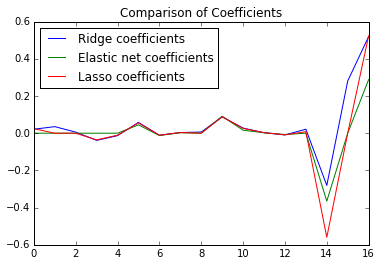

      Ridge R^2: 0.435066
      Lasso R^2: 0.436226
Elastic Net R^2: 0.466779


In [102]:
#plot the coefficients
plt.plot(R_coef, label='Ridge coefficients')
plt.plot(E_coef, label='Elastic net coefficients')
plt.plot(L_coef, label='Lasso coefficients')
plt.legend(loc='best')
plt.title("Comparison of Coefficients")
plt.show()

print ("      Ridge R^2: %f\n      Lasso R^2: %f\nElastic Net R^2: %f"
          % (R_score, L_score, E_score))

##ii) Polynomial Features

Polynomial Features genereates a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree.  
For example, if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].  
(http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)

In [48]:
# Polynomial Features
poly = preprocessing.PolynomialFeatures(2)
test_data_poly = poly.fit_transform(test_data)
dev_data_poly = poly.transform(dev_data) 
train_data_poly = poly.transform(train_data) 

print 'train data shape: ', train_data_poly.shape
print 'dev data shape: ', dev_data_poly.shape
print 'test data shape: ', test_data_poly.shape
print '\n'

# Train RidgeCV model using the training sets 
clf = linear_model.RidgeCV(alphas=[0.1, 0.2, 0.5, 1.0, 10.0, 20.0, 50.0, 100.0])
clf.fit(train_data_poly, train_labels)

# Model Summary
output_model_summary(clf, dev_data_poly, dev_labels, test_data_poly, test_labels)


train data shape:  (7000, 171)
dev data shape:  (2000, 171)
test data shape:  (1825, 171)


Coefficients: 
[  0.00000000e+00   1.01790258e-01  -3.76440284e-01  -4.04246987e-01
   5.24034218e-01   1.57246886e-01  -8.37106747e-02   1.05604347e-02
   2.19806424e-03   1.96059560e-01   2.30595671e-01  -1.49391882e-01
  -3.93717716e-02   3.84847167e-02   1.01790258e-01  -1.65849179e-01
   1.65849179e-01  -2.13905889e-01  -1.59427531e-01   3.36529570e-01
   2.92116956e-02   7.26934359e-02   7.10369977e-04  -4.45059558e-03
  -2.23841684e-03  -1.25535174e-03   3.58149730e-01  -2.35395785e-03
   1.47105674e-02  -1.50338308e-02   5.85242471e-02  -1.59427531e-01
   6.30608916e-02   3.87293668e-02  -1.72096288e-03  -3.76440284e-01
   0.00000000e+00  -2.81434181e-01   1.49721316e-02  -3.28169597e-03
   2.84288347e-03   4.94049532e-03  -1.04312318e+00   1.23957818e-02
   1.49547985e-01   6.52221743e-02  -2.67747814e-01   3.36529570e-01
  -9.22925307e-02  -2.84147753e-01  -1.32391531e-01  -4.04246987e

In [21]:
# Kaggle Submission with Polynomial features
X1_poly = poly.transform(X1)
X_poly =  poly.transform(X)
clf.fit(X_poly, Y)
pred = clf.predict(X1_poly)
generate_kaggle_submission(pred, "submission_poly_elastic.csv")



Generating Kaggle Submission File: submission_poly_elastic.csv
Shape of Kaggle Test Set:  (6493, 9)
Shape of Kaggle Test Set Prediction:  (6493,)
Shape of Submission Dataframe:  (6493, 2)


We are now at 3210.  We still have a ways to go, but we still have many more ideas.

##iii) SVR

Support Vector Regression performs classification by finding the hyperplane that maximizes the margin between classes. (http://www.saedsayad.com/support_vector_machine.htm)

One of the advantages of SVR is it can be used to avoid difficulties of using linear functions in high dimensional feature space. The loss function is used to penalize errors greater than the threshold.

In [103]:
svr = svm.SVR(kernel='linear')

# Train the model using the training sets
svr.fit(train_data, np.squeeze(train_labels))

# Model Summary
output_model_summary(svr, dev_data, dev_labels, test_data, test_labels)

Coefficients: 
[[-0.0108273  -0.05388881  0.01091433 -0.03555397  0.02008015 -0.06202439
   0.01414295 -0.00518587  0.00107309 -0.06944035 -0.0235859  -0.00375977
   0.01129483 -0.0108273   0.28990512 -0.28990512 -0.5225867 ]]

Intercept:  [ 3.10021306]

Residual sum of squares: 1.26

[DEV]  R^2 - Variance score: 0.39
[TEST] R^2 - Variance score: 0.40


In [107]:
# Kaggle Submission with SVR Linear
svr.fit(X, np.squeeze(Y))
pred = clf.predict(X1)
generate_kaggle_submission(pred, "submission_svr_linear.csv")



Generating Kaggle Submission File: submission_svr_linear.csv
Shape of Kaggle Test Set:  (6493, 9)
Shape of Kaggle Test Set Prediction:  (6493,)
Shape of Submission Dataframe:  (6493, 2)


Well, that took a while to run, but unfortunately we have no improvement. We are still at 3208.

##iv) Side-Tracks

Before we go any farther, let's look at some different things we can do to help improve our score.

### a) Cross-Validation

With Cross Validation, we can shuffle split the data any number of times and specify how large the test size should be.  This means we can see how the model performs with multiple variations of the training and development data, and the data also does not need to be sliced in whole continuous chunck, as we use an index for identifying which data rows are used.


In [54]:
#  OLS with Cross Validation
ols = linear_model.LinearRegression()

#Here we define the ShuffleSplit, using 5 iterations, a test size of 25%
ss = cross_validation.ShuffleSplit(X.shape[0], n_iter=5, test_size=0.25, random_state=0)
count = 1

#Here we iterate through our 5 pairs of train and test data:
for train_index, test_index in ss:
    print("\n [Iteration:%d] Num of Training: %s,  Num of Test: %s" % (count, len(train_index), len(test_index)))
    # Train the model using the training sets
    ols.fit(X[train_index], Y[train_index])

    # Model Summary
    output_model_summary(ols, X[test_index], Y[test_index])
    
    count += 1


 [Iteration:1] Num of Training: 8118,  Num of Test: 2707
Coefficients: 
[  3.03522237e+11   5.70800469e-02   1.71380988e-02  -2.79625596e-02
   1.29556297e-02   2.90992329e-02  -1.23918075e-02   3.13799885e-03
   2.23096339e-02   8.85957299e-02   2.69261601e-02   2.64171258e-03
  -8.09110464e-03  -3.03522237e+11   1.04111053e+08   1.04111054e+08
   5.26041382e-01]

Intercept:  -104111050.468
Residual sum of squares: 1.07
[DEV]  R^2 - Variance score: 0.50



 [Iteration:2] Num of Training: 8118,  Num of Test: 2707
Coefficients: 
[ -2.49135556e+11   3.10074808e-02   3.21563757e-02  -8.79590614e-03
  -7.30591630e-03   4.70445390e-02  -1.32599805e-02   3.51126277e-03
   1.44346516e-02   8.79856753e-02   3.13459708e-02   2.99906727e-03
  -8.08920216e-03   2.49135556e+11   2.08949128e+08   2.08949129e+08
   4.98624537e-01]

Intercept:  -208949125.742
Residual sum of squares: 1.08
[DEV]  R^2 - Variance score: 0.50



 [Iteration:3] Num of Training: 8118,  Num of Test: 2707
Coefficients: 
[-0

### a) Multiple Models

To this point we have also been using all the data to test the models. As shown in the data analysis sections, there is a different pattern of use between casual and registered users.

We previously created variables X_R, Y_R and X1_R for registered users, and X_C, Y_C and X1_C for casual users (X1 is the Kaggle data set). All X_R and X_C have the same number of rows. The difference comes in which data features are used.

Let's try it using the simple linear regression model.

In [90]:
#create the data variables for registered users
test_r, test_r_labels = X_R[9000:], Y_R[9000:]
dev_r, dev_r_labels = X_R[7000:9000], Y_R[7000:9000]
train_r, train_r_labels = X_R[:7000], Y_R[:7000]

#create the data variables for casual users
test_c, test_c_labels = X_C[9000:], Y_C[9000:]
dev_c, dev_c_labels = X_C[7000:9000], Y_C[7000:9000]
train_c, train_c_labels = X_C[:7000], Y_C[:7000]

#create the data variables for casual users
test_c, test_c_labels = X_C[9000:], Y_C[9000:]
dev_c, dev_c_labels = X_C[7000:9000], Y_C[7000:9000]
train_c, train_c_labels = X_C[:7000], Y_C[:7000]

# LinearRegression classifiers
lr   = linear_model.LinearRegression() #all
lr_c = linear_model.LinearRegression() #casual
lr_r = linear_model.LinearRegression() #registered

# fit the models
lr.fit(train_data, train_labels)       #all
lr_c.fit(train_c, train_c_labels) #casual
lr_r.fit(train_r, train_r_labels) #registered

# get the predictions
pred = lr.predict(dev_data)        #all
pred_c = lr_c.predict(dev_c)  #casual
pred_r = lr_r.predict(dev_r)  #registered


print "All users [count]"
output_model_summary(lr, dev_data, dev_labels)
print "-" * 80
print "Registered users [registered]"
output_model_summary(lr_r, dev_r, dev_r_labels)
print "-" * 80
print "Casual users [casual]"
output_model_summary(lr_c, dev_c, dev_c_labels)

All users [count]
Coefficients: 
[ 0.02190552  0.04121215  0.00783243 -0.03933923 -0.01341353  0.05804505
 -0.01078207  0.00366856  0.00647047  0.08786816  0.02806844  0.00262821
 -0.00921487  0.02190552 -0.28385695  0.28385695  0.53250213]

Intercept:  2.65688359203
Residual sum of squares: 1.16
[DEV]  R^2 - Variance score: 0.43


--------------------------------------------------------------------------------
Registered users [registered]
Coefficients: 
[  5.06455852e+10  -2.33386846e+01   1.10085060e-01   3.35817874e+00
  -2.63289708e-01  -2.06643487e-01   1.37403594e+07   1.37403520e+07
   1.37403110e+07   1.37402353e+07   9.45547778e+00   4.08025893e+00
  -2.07252818e-01  -3.96048626e+01   5.44511464e+00   2.00515348e-01
   1.27926679e+00   6.00659528e-02  -7.61268876e+06  -7.61267401e+06
  -7.61260491e+06  -7.61258142e+06  -7.61258006e+06  -7.61264230e+06
   2.02582341e+11  -5.06455852e+10  -9.21946334e+00   1.55981941e+02]

Intercept:  -4.07393093993e+14
Residual sum of squares:

We end up with some really nice variance scores for Registered and Casual users in predicting the number of Registered and Casual users.

Since we know the Count for each hour is the sum of Registered and Casual, how do we do when we add our models together?

In [91]:
combined = pred_c + pred_r
print combined

# The mean square error
print ("\nResidual sum of squares: %.2f" % np.mean((np.rint(combined) - dev_labels) ** 2))
    
# Explained variance score: 1 is perfect prediction
slope, intercept, r_value, p_value, std_err = stats.linregress(combined,dev_labels)
print "R^2 - Variance score: %.2f" %r_value**2


[  69.50488281   76.33496094   47.81835938 ...,  328.8984375   339.95117188
  381.25097656]

Residual sum of squares: 76651.67
R^2 - Variance score: 0.61


Let's see what we get using two models with simple linear regression but with the full Kaggle data set.

In [92]:
# fit the models
lr_c.fit(X_C, Y_C) #casual
lr_r.fit(X_R, Y_R) #registered

# get the predictions
pred_c = lr_c.predict(X1_C)  #casual
pred_r = lr_r.predict(X1_R)  #registered
print pred_c
print pred_r
print pred_c + pred_r

generate_kaggle_submission(pred_c + pred_r, "multiple_models_linear.csv")

[ -2.64296875e+01  -1.89238281e+01  -1.79921875e+01 ...,   3.92626954e+09
   3.92626954e+09   3.92626954e+09]
[ -7.54843750e+01  -6.19062500e+01  -6.08750000e+01 ...,   4.31354682e+10
   4.31354682e+10   4.31354682e+10]
[ -1.01914062e+02  -8.08300781e+01  -7.88671875e+01 ...,   4.70617377e+10
   4.70617377e+10   4.70617377e+10]


Generating Kaggle Submission File: multiple_models_linear.csv
Shape of Kaggle Test Set:  (6493, 9)
Shape of Kaggle Test Set Prediction:  (6493,)
Shape of Submission Dataframe:  (6493, 2)
